# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images=np.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Project/images.npy')

In [4]:
labels=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Project/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [5]:
images.shape

(4750, 128, 128, 3)

In [6]:
labels.shape

(4750, 1)

* We have 4750 128*128 color images in the Dataset

## Exploratory Data Analysis

In [7]:
labels.nunique()

,0
Label,12


* We have 12 different classes of plants

In [8]:
labels.value_counts(normalize=True)

,proportion
Label,
Loose Silky-bent,0.137684
Common Chickweed,0.128632
Scentless Mayweed,0.108632
Small-flowered Cranesbill,0.104421
Fat Hen,0.100000
Charlock,0.082105
Sugar beet,0.081053
Cleavers,0.060421
Black-grass,0.055368


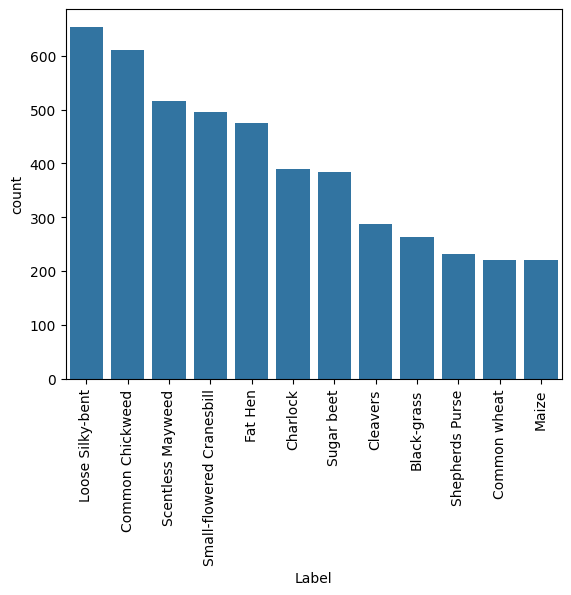

In [9]:
plt.xticks(rotation=90)
sns.countplot(data=labels,x=labels['Label'], order=labels['Label'].value_counts().index[:])
plt.show()

* The dataset is a bit imbalanced - for example, we have 3 times more images of Loose Silky-Bent and Common Chickweed than we have of Shepherds Purse, Common wheat and Maize

In [10]:
def display_random_images(images, labels):
    categories = labels['Label'].unique()  # Get the unique categories

    # Set up a figure with as many subplots as there are categories
    plt.figure(figsize=(12, 8))

    for i, category in enumerate(categories):
        # Get the indices of all images that belong to the current category
        category_indices = labels.index[labels['Label'] == category].tolist()

        # Select a random index from these category indices
        random_index = random.choice(category_indices)

        # Select the corresponding image from the images array
        random_image = images[random_index]

        # Display the image
        plt.subplot(3, 4, i + 1)
        plt.imshow(random_image)
        plt.title(category)
        plt.axis('off')  # Remove axes for better visualization

    plt.tight_layout()
    plt.show()

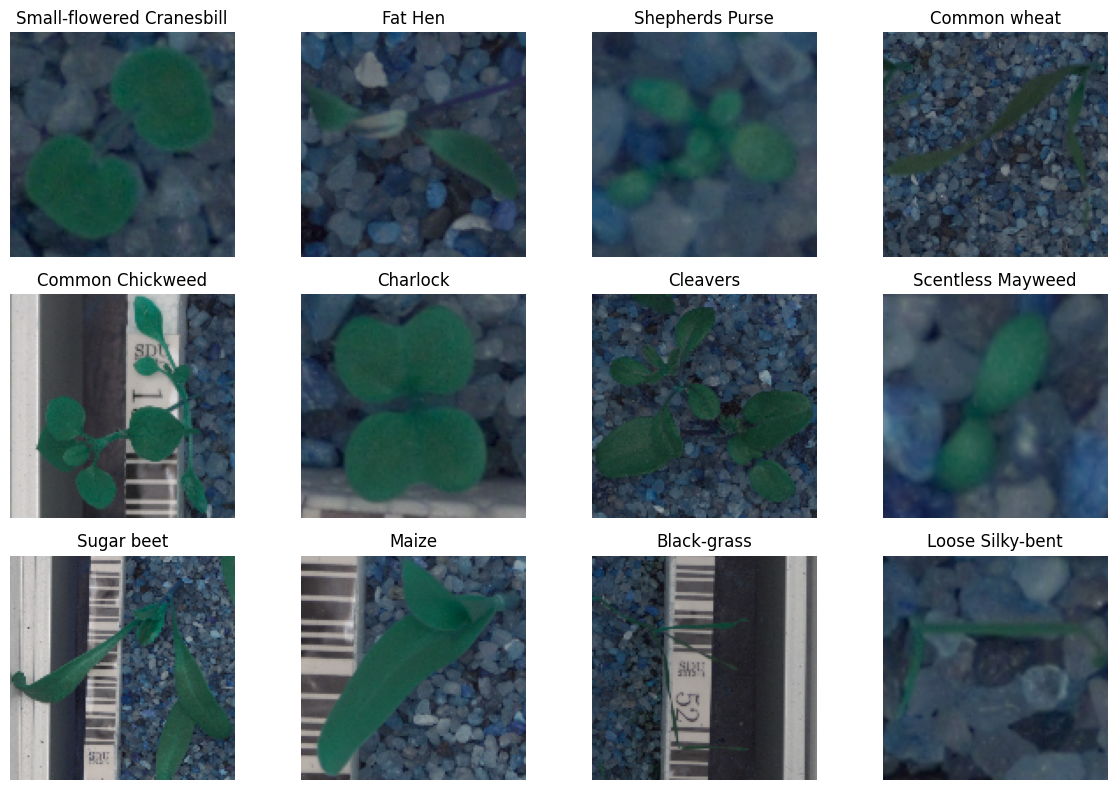

In [11]:
display_random_images(images, labels)

* Some images are more blurred than the others
* The background also differs - all plants seem to have small rocks covering the ground where the plant is growing, but a lot of pictures also show the edge of the plantbed in them, which is black and white and have a barcode-like image on it. I believe this black and white addition can influence the training results
* Some plants look very similar - for example I am not sure I would be able to differentiate Black-grass from Loose Silky-bent

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [12]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [13]:
images_downsized=[]
dimensions=(64,64)
for i in range(len(images)):
    images_downsized.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

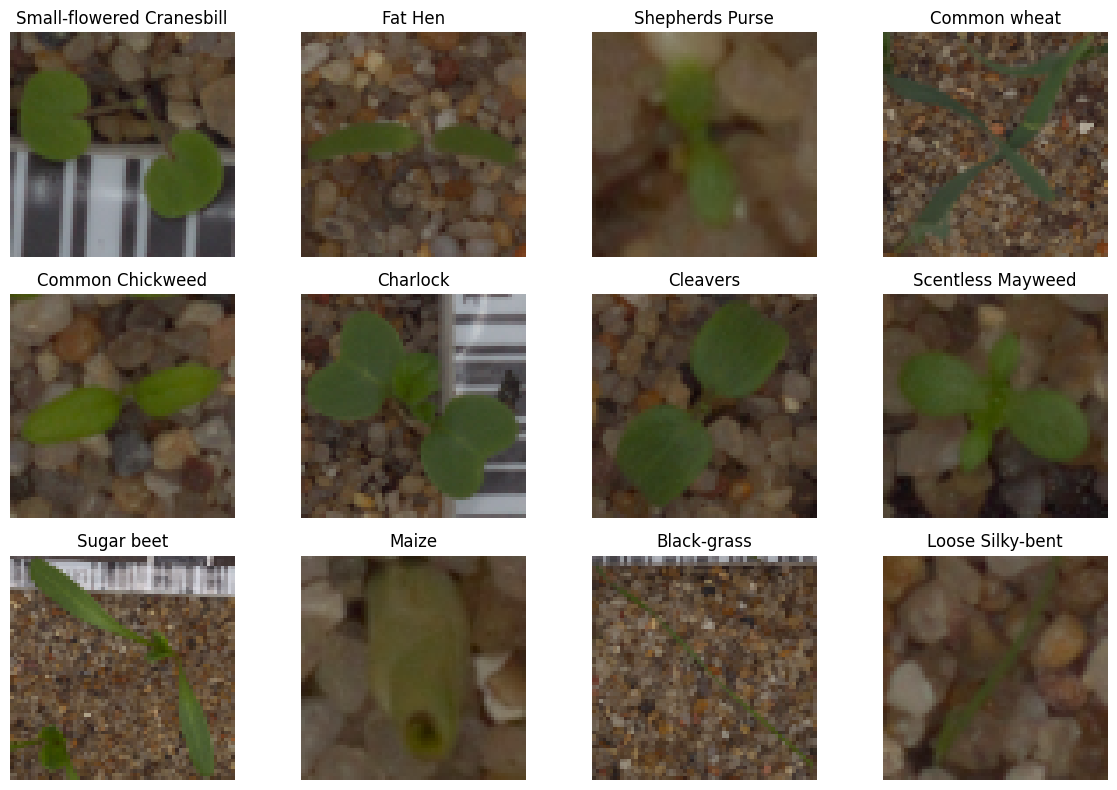

In [14]:
display_random_images(images_downsized,labels)

### Data Preparation for Modeling

####Split the dataset into train, validation and test

In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_downsized),labels , test_size=0.1, random_state=2,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=2,stratify=y_temp)

In [16]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


#### Encode the target labels

In [17]:
#Encoding the target variables using LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

#### Data Normalization

In [18]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

###Utility functions

In [19]:
def plot_metrics(history):
    """
    Function to plot Loss and Accuracy side by side.
    history: an object which stores the metrics and losses.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # Creating a subplot with 1 row, 2 columns

    # Plotting Loss
    ax[0].plot(history.history['loss'])  # Plotting the train loss
    ax[0].plot(history.history['val_loss'])  # Plotting the validation loss
    ax[0].set_title('Model Loss')  # Title for Loss subplot
    ax[0].set_xticks(range(0,len(history.history['loss'])+1,5))
    ax[0].set_ylabel('Loss')  # Y-axis label
    ax[0].set_xlabel('Epoch')  # X-axis label
    ax[0].legend(['Train', 'Validation'], loc='upper right')  # Legend for Loss subplot

    # Plotting accuracy
    ax[1].plot(history.history['accuracy'])  # Plotting the train accuracy
    ax[1].plot(history.history['val_accuracy'])  # Plotting the validation accuracy
    ax[1].set_title('Model accuracy')  # Title for accuracy subplot
    ax[1].set_xticks(range(0,len(history.history['loss'])+1,5))
    ax[1].set_ylabel('accuracy')  # Y-axis label
    ax[1].set_xlabel('Epoch')  # X-axis label
    ax[1].legend(['Train', 'Validation'], loc='lower right')  # Legend for accuracy subplot

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [20]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    #Making predictions
    pred = model.predict(predictors)

    #Converting probabilities to class labels
    pred_classes = np.argmax(pred, axis=1)
    target_classes=np.argmax(target,axis=1)

    #Printing the classification report
    print(classification_report(target_classes, pred_classes, target_names=enc.classes_))

    #Plotting the heatmap using confusion matrix
    cm = confusion_matrix(target_classes, pred_classes)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=enc.classes_, yticklabels=enc.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [21]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_metrics_train_val(model, X_train, y_train, X_val, y_val):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    X_train, y_train - training dataset
    X_val, y_val - validation dataset
    """

    #Making predictions
    pred_train = np.argmax(model.predict(X_train), axis=1)
    pred_val = np.argmax(model.predict(X_val),axis=1)
    y_train_classes=np.argmax(y_train,axis=1)
    y_val_classes=np.argmax(y_val,axis=1)

    #compute metrics for training set
    acc_train = accuracy_score(y_train_classes, pred_train)  # to compute Accuracy
    recall_train = recall_score(y_train_classes, pred_train, average='weighted')  # to compute Recall
    precision_train = precision_score(y_train_classes, pred_train, average='weighted')  # to compute Precision
    f1_train = f1_score(y_train_classes, pred_train, average='weighted')  # to compute F1-score

    #compute metrics for validation set
    acc_val = accuracy_score(y_val_classes, pred_val)  # to compute Accuracy
    recall_val = recall_score(y_val_classes, pred_val, average='weighted')  # to compute Recall
    precision_val = precision_score(y_val_classes, pred_val, average='weighted')  # to compute Precision
    f1_val = f1_score(y_val_classes, pred_val, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc_train,acc_val],
            "Recall": [recall_train,recall_val],
            "Precision": [precision_train,precision_val],
            "F1": [f1_train,f1_val]

        },
        index=["Training data", "Validation data"]
    )

    return df_perf

###Model

In [22]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [23]:
# Building the model
model1 = Sequential()
model1.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model1.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,804 (1.40 MB)

 Trainable params: 365,804 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

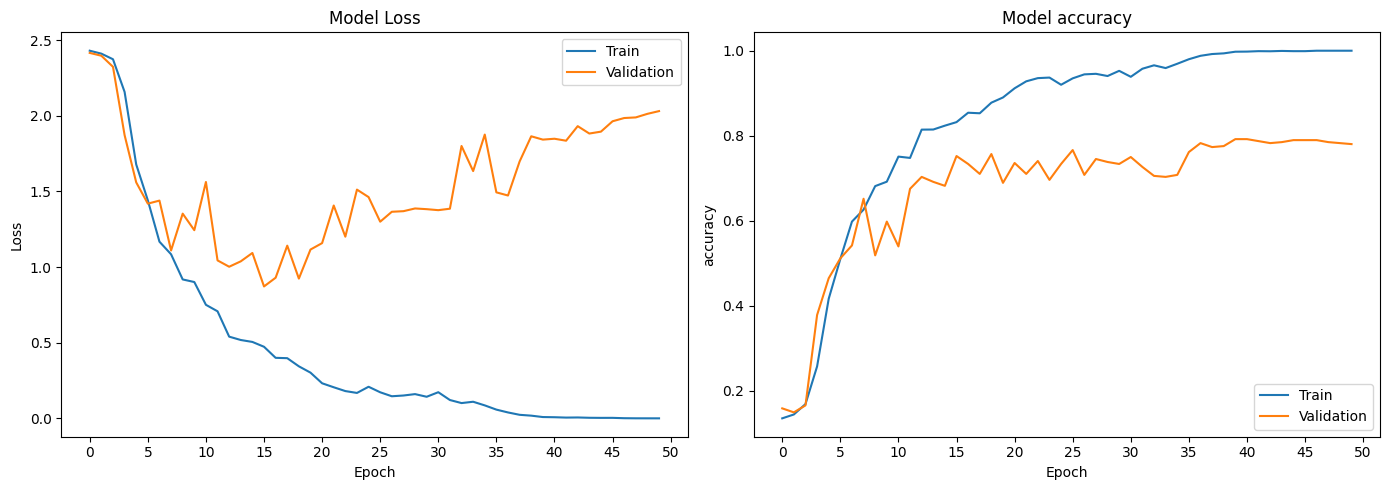

In [25]:
plot_metrics(history1)

In [26]:
model1_perf=model_metrics_train_val(model1,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model1_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.780374,0.780374,0.780616,0.776901


In [27]:
#Checking on test data
accuracy1 = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - 120ms/step - accuracy: 0.7874 - loss: 1.6292


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
                           precision    recall  f1-score   support

              Black-grass       0.43      0.46      0.44        26
                 Charlock       0.87      1.00      0.93        39
                 Cleavers       0.93      0.86      0.89        29
         Common Chickweed       0.85      0.87      0.86        61
             Common wheat       0.68      0.68      0.68        22
                  Fat Hen       0.69      0.74      0.71        47
         Loose Silky-bent       0.73      0.80      0.76        65
                    Maize       0.78      0.82      0.80        22
        Scentless Mayweed       0.82      0.79      0.80        52
          Shepherds Purse       0.80      0.52      0.63        23
Small-flowered Cranesbill       0.90      0.90      0.90        50
               Sugar beet       0.87      0.69      0.77        39

                 accuracy                           0.79       475
                macr

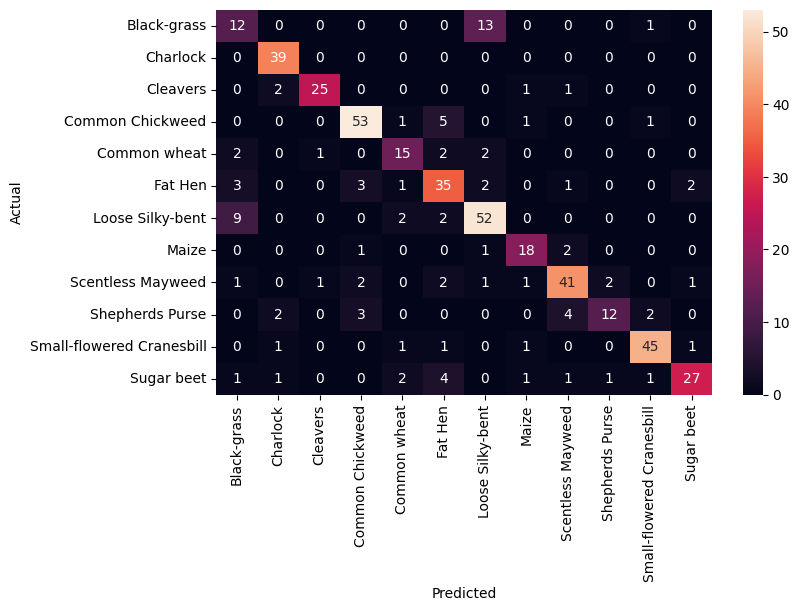

In [28]:
#Checking on test data
model_performance(model1,X_test_normalized,y_test_encoded)

* We see ~79% Accuracy on test data, but the model is a bit overfit - there is a  difference between training and validation Accuracy.
* The metrics also vary accross the categories. For example, from the confusion matrix we see that the model is having a very hard time differentiating Loose Silky-bent from Black-grass

## Model Performance Improvement

### Model with dropout and batch normalization

In [29]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [30]:
# Building the model
model2 = Sequential()
model2.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model2.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
history2 = model2.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

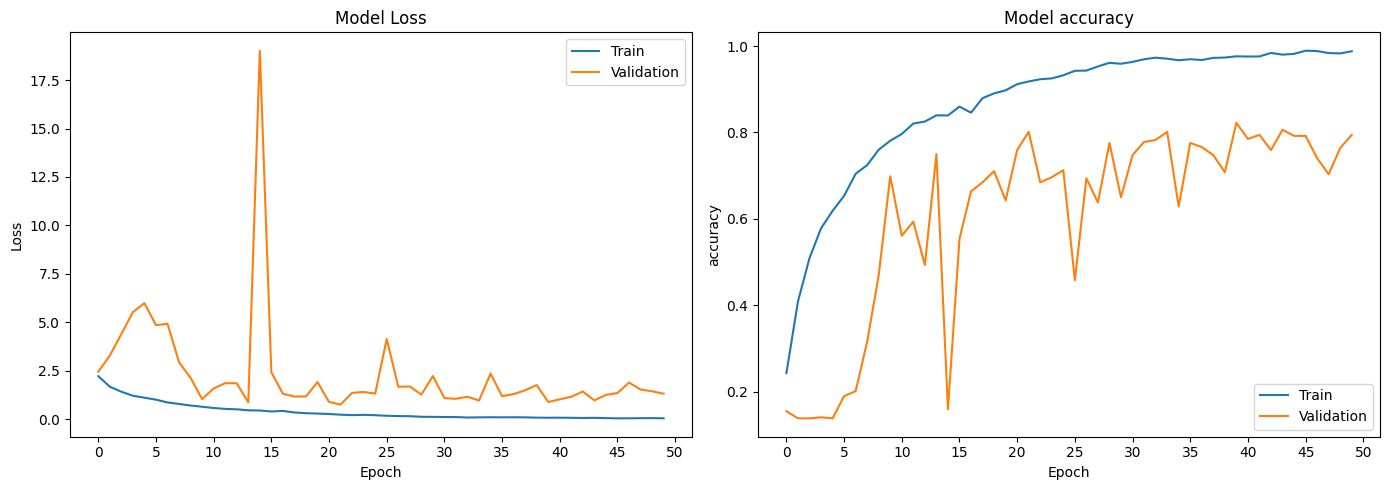

In [32]:
plot_metrics(history2)

In [33]:
model2_perf=model_metrics_train_val(model2,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model2_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Accuracy,Recall,Precision,F1
Training data,0.962308,0.962308,0.966590,0.962754
Validation data,0.794393,0.794393,0.807699,0.792781


In [34]:
#Checking on test data
accuracy2 = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 66ms/step - accuracy: 0.8021 - loss: 1.3888


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
                           precision    recall  f1-score   support

              Black-grass       0.33      0.46      0.39        26
                 Charlock       0.97      0.95      0.96        39
                 Cleavers       0.82      0.97      0.89        29
         Common Chickweed       0.86      0.92      0.89        61
             Common wheat       0.92      0.55      0.69        22
                  Fat Hen       0.74      0.83      0.78        47
         Loose Silky-bent       0.70      0.80      0.75        65
                    Maize       1.00      0.82      0.90        22
        Scentless Mayweed       0.93      0.71      0.80        52
          Shepherds Purse       0.92      0.48      0.63        23
Small-flowered Cranesbill       0.80      0.94      0.86        50
               Sugar beet       0.97      0.82      0.89        39

                 accuracy                           0.80       475
                macr

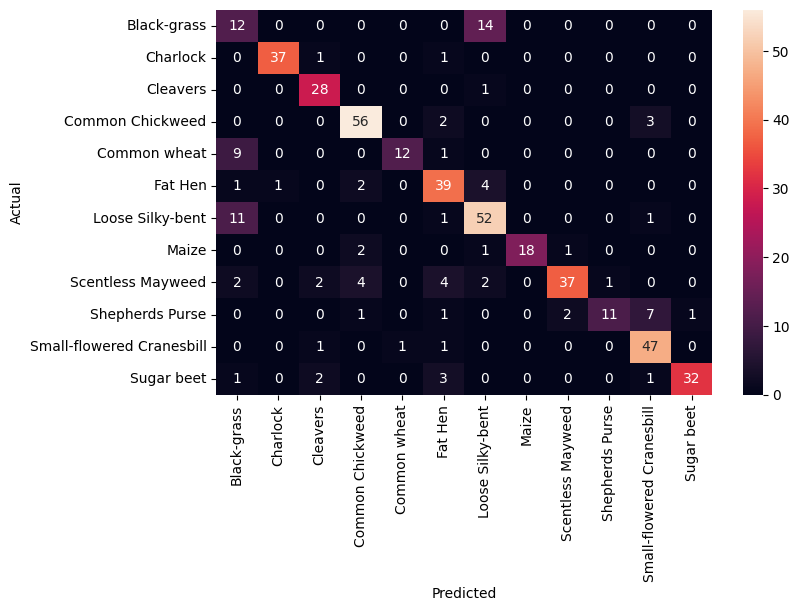

In [35]:
#Checking on test data
model_performance(model2,X_test_normalized,y_test_encoded)

* We see that the overall metrics have slightly improved in comparison to the previous model, but the convergence is less smooth and there is still an overfit

### With only BatchNormalization

In [36]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [37]:
# Building the model
model3 = Sequential()
model3.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model3.add(MaxPooling2D(2,2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model3.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [38]:
history3 = model3.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

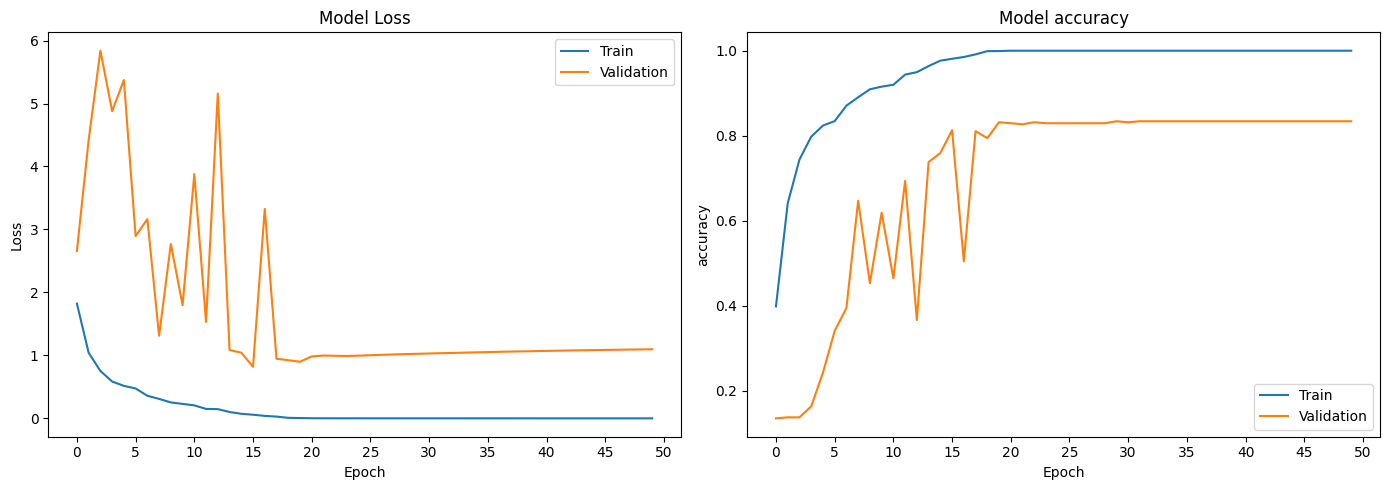

In [39]:
plot_metrics(history3)

In [40]:
model3_perf=model_metrics_train_val(model3,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model3_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.834112,0.834112,0.830496,0.829767


In [41]:
#Checking on test data
accuracy3 = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 47ms/step - accuracy: 0.8632 - loss: 0.9231


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                           precision    recall  f1-score   support

              Black-grass       0.67      0.62      0.64        26
                 Charlock       0.82      0.95      0.88        39
                 Cleavers       0.93      0.86      0.89        29
         Common Chickweed       0.92      0.95      0.94        61
             Common wheat       0.78      0.95      0.86        22
                  Fat Hen       0.84      0.87      0.85        47
         Loose Silky-bent       0.82      0.85      0.83        65
                    Maize       0.86      0.82      0.84        22
        Scentless Mayweed       0.89      0.90      0.90        52
          Shepherds Purse       0.93      0.57      0.70        23
Small-flowered Cranesbill       0.94      0.88      0.91        50
               Sugar beet       0.92      0.90      0.91        39

                 accuracy                           0.86       475
                macr

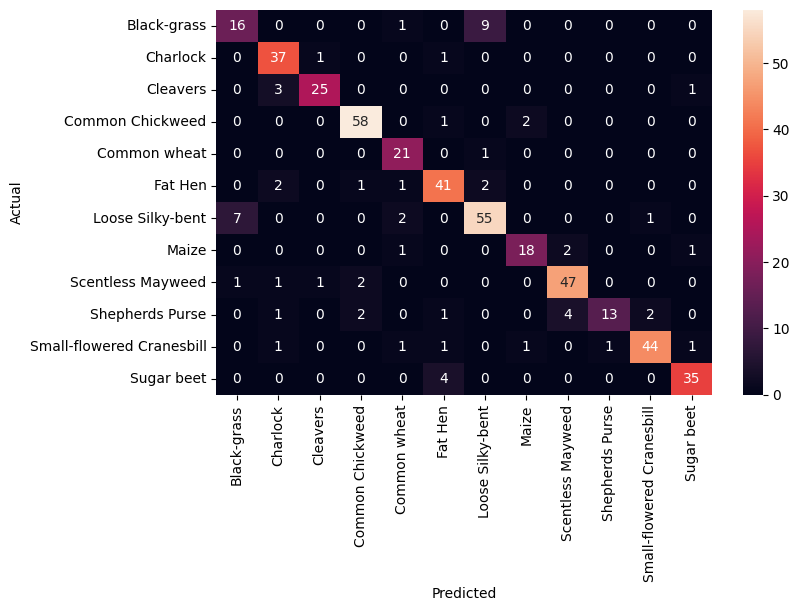

In [42]:
#Checking on test data
model_performance(model3,X_test_normalized,y_test_encoded)

* The overall metrics improved
* The model is still somewhat overfit, and the metrics stop improving after 20 epochs for both training (which hits 1.0 at that point) and validation

### Trying Adam optimizer

In [43]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [44]:
# Building the model
model4 = Sequential()
model4.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model4.add(MaxPooling2D(2,2))
model4.add(BatchNormalization())
model4.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model4.add(MaxPooling2D(2,2))
model4.add(BatchNormalization())
model4.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model4.add(MaxPooling2D(2,2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model4.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [45]:
history4 = model4.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

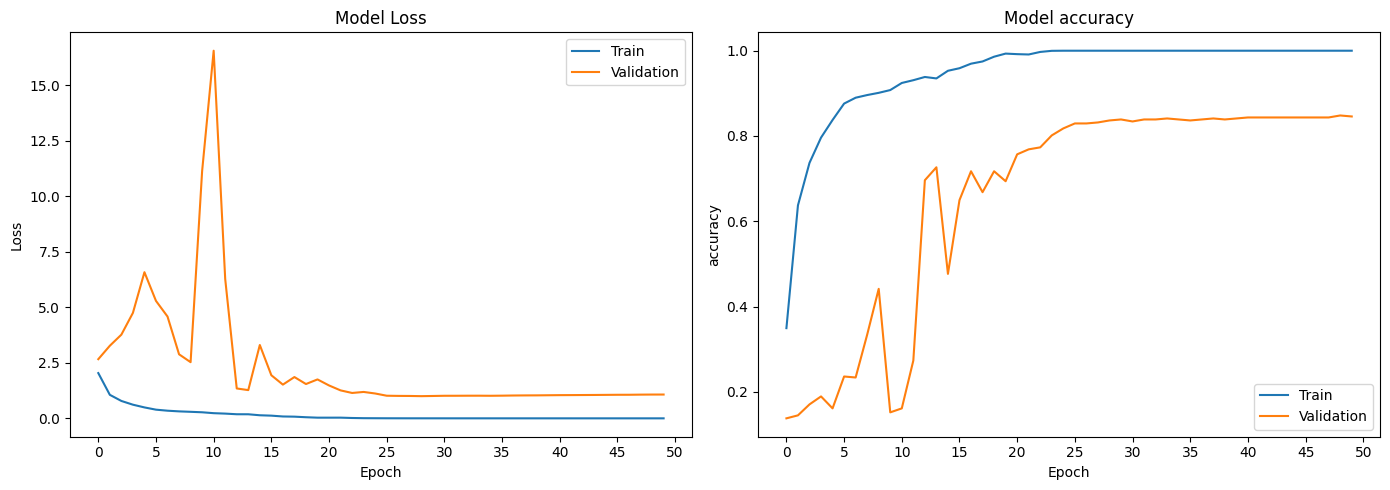

In [46]:
plot_metrics(history4)

In [47]:
model4_perf=model_metrics_train_val(model4,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model4_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.845794,0.845794,0.844386,0.842199


In [48]:
#Checking on test data
accuracy4 = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 69ms/step - accuracy: 0.8400 - loss: 0.8225


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                           precision    recall  f1-score   support

              Black-grass       0.50      0.54      0.52        26
                 Charlock       0.81      1.00      0.90        39
                 Cleavers       1.00      0.86      0.93        29
         Common Chickweed       0.90      0.93      0.92        61
             Common wheat       0.78      0.95      0.86        22
                  Fat Hen       0.86      0.79      0.82        47
         Loose Silky-bent       0.83      0.80      0.81        65
                    Maize       0.82      0.82      0.82        22
        Scentless Mayweed       0.84      0.88      0.86        52
          Shepherds Purse       0.93      0.57      0.70        23
Small-flowered Cranesbill       0.88      0.86      0.87        50
               Sugar beet       0.89      0.87      0.88        39

                 accuracy                           0.84       475
                macr

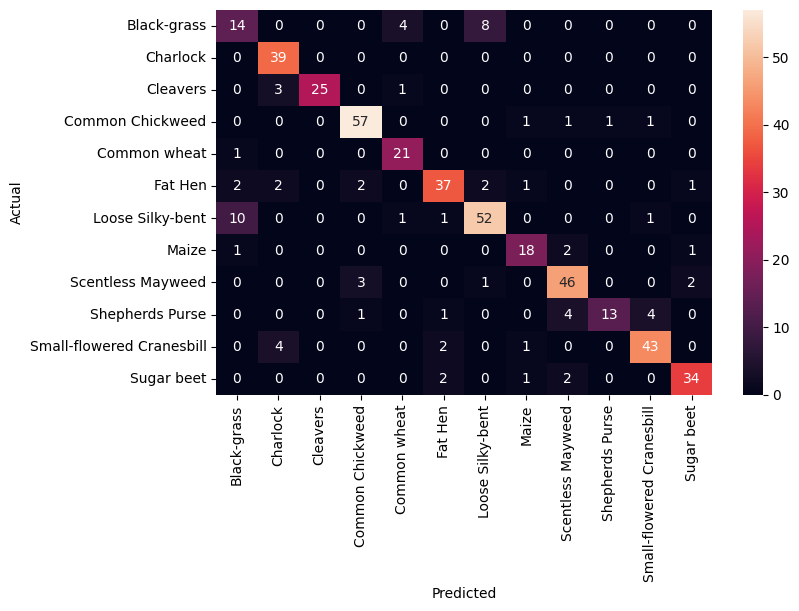

In [49]:
#Checking on test data
model_performance(model4,X_test_normalized,y_test_encoded)

* We see a similar picture to the previous models with metrics flattenning out after 25 epoch
* The metrics are comparable, and there is still some degree of overfit

### Using Adam optimizer with dropout

In [50]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [51]:
# Building the model
model5 = Sequential()
model5.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model5.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [52]:
history5 = model5.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

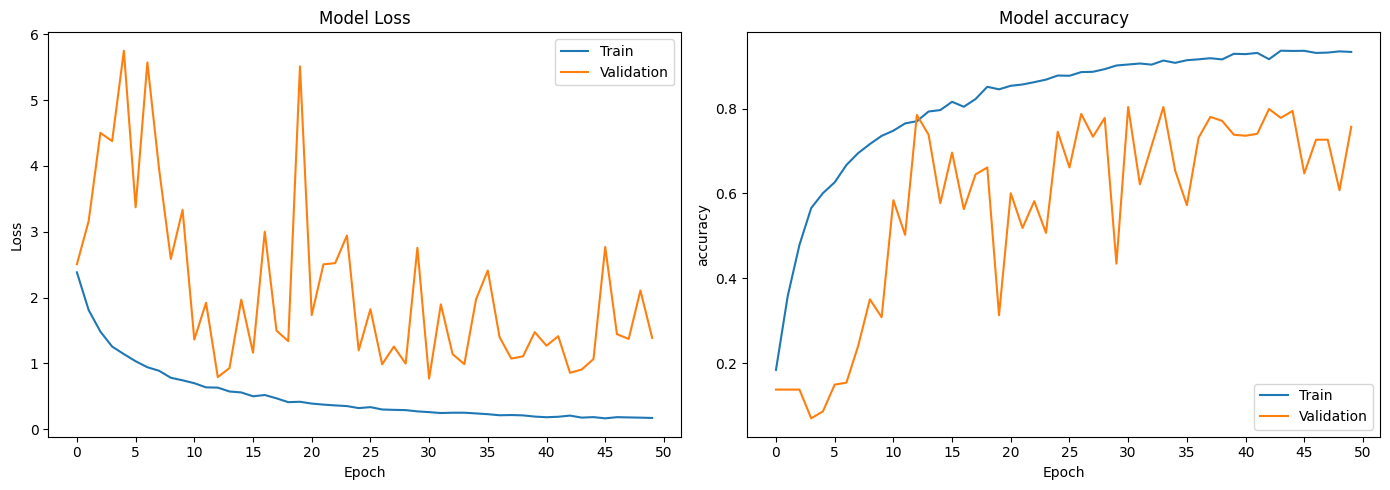

In [53]:
plot_metrics(history5)

In [54]:
model5_perf=model_metrics_train_val(model5,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model5_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Accuracy,Recall,Precision,F1
Training data,0.880166,0.880166,0.918017,0.882023
Validation data,0.757009,0.757009,0.813813,0.757316


In [55]:
#Checking on test data
accuracy5 = model5.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 47ms/step - accuracy: 0.7684 - loss: 1.0950


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
                           precision    recall  f1-score   support

              Black-grass       0.32      0.85      0.46        26
                 Charlock       0.89      1.00      0.94        39
                 Cleavers       0.96      0.90      0.93        29
         Common Chickweed       0.92      0.95      0.94        61
             Common wheat       0.94      0.77      0.85        22
                  Fat Hen       0.70      0.85      0.77        47
         Loose Silky-bent       0.77      0.37      0.50        65
                    Maize       0.90      0.86      0.88        22
        Scentless Mayweed       0.93      0.52      0.67        52
          Shepherds Purse       0.82      0.39      0.53        23
Small-flowered Cranesbill       0.83      0.96      0.89        50
               Sugar beet       0.77      0.92      0.84        39

                 accuracy                           0.77       475
                macr

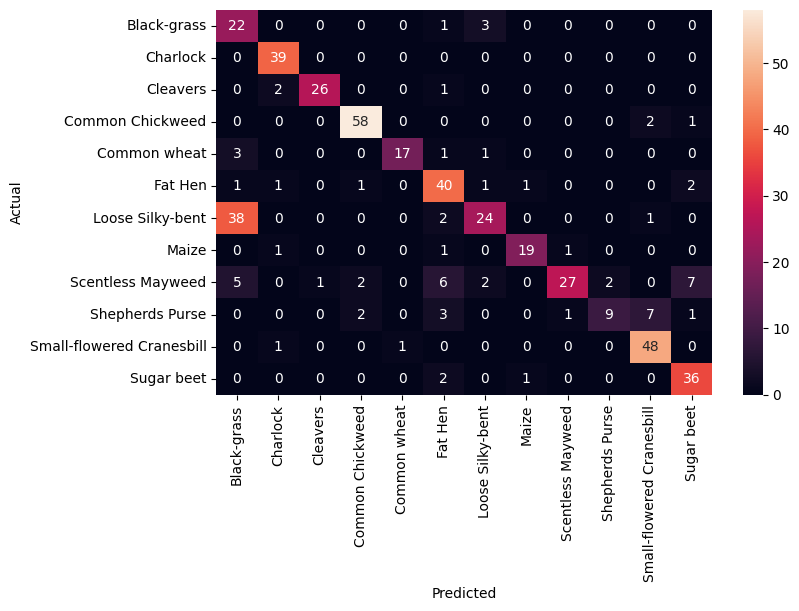

In [56]:
#Checking on test data
model_performance(model5,X_test_normalized,y_test_encoded)

* Adding Dropout makes for a less smooth convergence and the overall metrics are worse than without Dropout

###Adam with BatchNormalization and changing learning rate

In [57]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [58]:
# Code to monitor validation accuracy and adjust the learning rate
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  #Quantity to be monitored
    patience=3,  #Number of epochs with no improvement after which learning rate will be reduced.
    factor=0.5, #Factor by which the learning rate will be reduced.
    min_lr=0.00001  # Lower bound on the learning rate.
)

In [59]:
# Building the model
model6 = Sequential()
model6.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model6.add(MaxPooling2D(2,2))
model6.add(BatchNormalization())
model6.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model6.add(MaxPooling2D(2,2))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model6.add(MaxPooling2D(2,2))
model6.add(Flatten())
model6.add(Dense(128, activation='relu'))
model6.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model6.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [60]:
history6 = model6.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            callbacks=[learning_rate_reduction],
            verbose=0
)

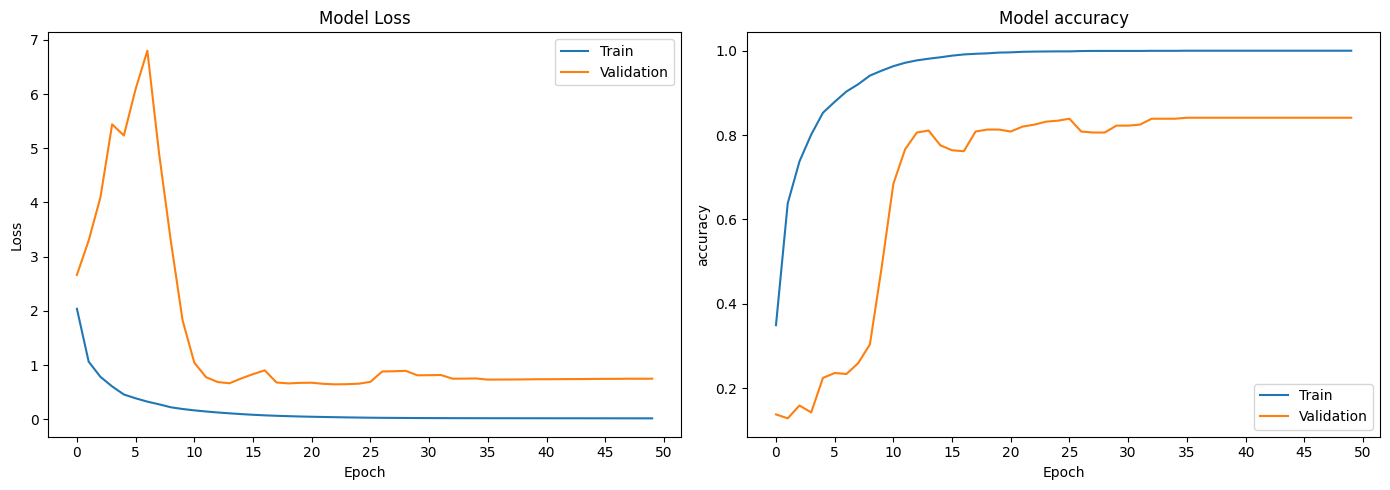

In [61]:
plot_metrics(history6)

In [62]:
model6_perf=model_metrics_train_val(model6,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model6_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Accuracy,Recall,Precision,F1
Training data,0.999740,0.999740,0.999741,0.999740
Validation data,0.841121,0.841121,0.837278,0.833088


In [63]:
#Checking on test data
accuracy6 = model6.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 74ms/step - accuracy: 0.8211 - loss: 0.6314


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
                           precision    recall  f1-score   support

              Black-grass       0.58      0.54      0.56        26
                 Charlock       0.83      0.97      0.89        39
                 Cleavers       0.92      0.83      0.87        29
         Common Chickweed       0.85      0.95      0.90        61
             Common wheat       0.75      0.95      0.84        22
                  Fat Hen       0.85      0.70      0.77        47
         Loose Silky-bent       0.78      0.78      0.78        65
                    Maize       0.82      0.82      0.82        22
        Scentless Mayweed       0.80      0.83      0.81        52
          Shepherds Purse       0.71      0.52      0.60        23
Small-flowered Cranesbill       0.94      0.88      0.91        50
               Sugar beet       0.87      0.87      0.87        39

                 accuracy                           0.82       475
                macr

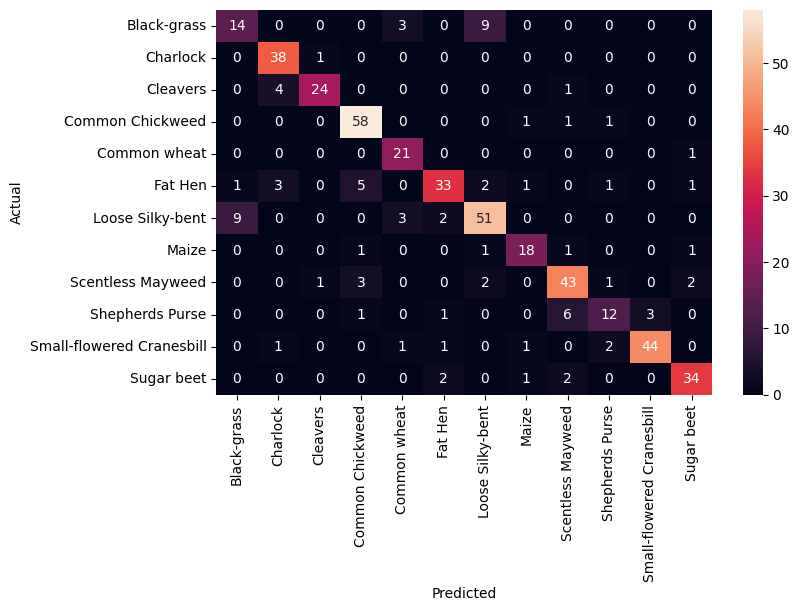

In [64]:
#Checking on test data
model_performance(model6,X_test_normalized,y_test_encoded)

* adjusting the Learning rate during training doesn't help us avoid the metrics hitting plateau
* overall metrics stay comparable to the previous models
* from the confusion matrix we can see that there is a bit less confusion between Black-grass and Loose silky-bent, but these two are still the most prolematic ones

###Using Data Augmentation

In [65]:
# Data Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate the images by up to 30 degrees
    horizontal_flip=True,  # Flip the images horizontally
    fill_mode='nearest'  # Fill pixels that may be lost after augmentation
)

In [66]:
# Augment the data using the `flow` method
train_generator = train_datagen.flow(
    X_train_normalized,
    y_train_encoded,
    batch_size=64,  # Set batch size
    shuffle=False  # Shuffle the data for each epoch
)

In [67]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [68]:
# Building the model
model7 = Sequential()
model7.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model7.add(MaxPooling2D(2,2))
model7.add(Flatten())
model7.add(Dense(128, activation='relu'))
model7.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model7.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [69]:
# Train the model with augmented data and class weights
history7 = model7.fit(
    train_generator,
    steps_per_epoch=X_train_normalized.shape[0] // 64,  # Total images divided by batch size
    epochs=50,  # Number of epochs
    validation_data=(X_val_normalized,y_val_encoded),
    batch_size=64,
    callbacks=[learning_rate_reduction],
    verbose=0
)

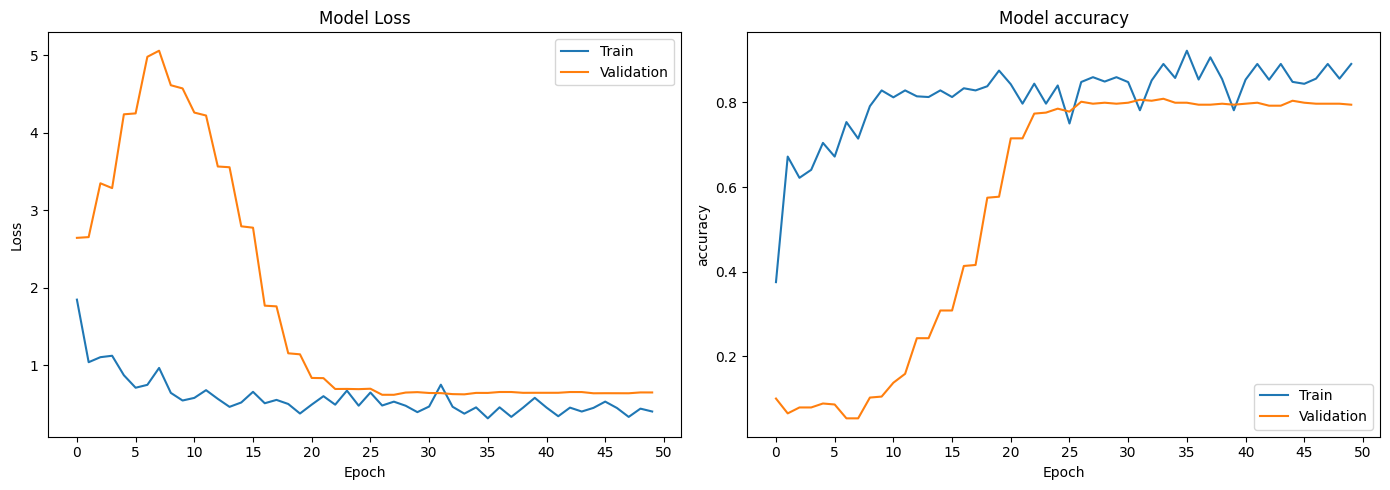

In [70]:
plot_metrics(history7)

In [71]:
model7_perf=model_metrics_train_val(model7,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model7_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,Accuracy,Recall,Precision,F1
Training data,0.848193,0.848193,0.843959,0.843338
Validation data,0.794393,0.794393,0.798404,0.787750


In [72]:
#Checking on test data
accuracy7 = model7.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 74ms/step - accuracy: 0.8021 - loss: 0.5658


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
                           precision    recall  f1-score   support

              Black-grass       0.55      0.42      0.48        26
                 Charlock       0.79      0.95      0.86        39
                 Cleavers       0.96      0.83      0.89        29
         Common Chickweed       0.81      0.95      0.87        61
             Common wheat       0.66      0.95      0.78        22
                  Fat Hen       0.89      0.66      0.76        47
         Loose Silky-bent       0.80      0.78      0.79        65
                    Maize       0.76      0.86      0.81        22
        Scentless Mayweed       0.77      0.71      0.74        52
          Shepherds Purse       1.00      0.39      0.56        23
Small-flowered Cranesbill       0.90      0.94      0.92        50
               Sugar beet       0.78      0.92      0.85        39

                 accuracy                           0.80       475
                macr

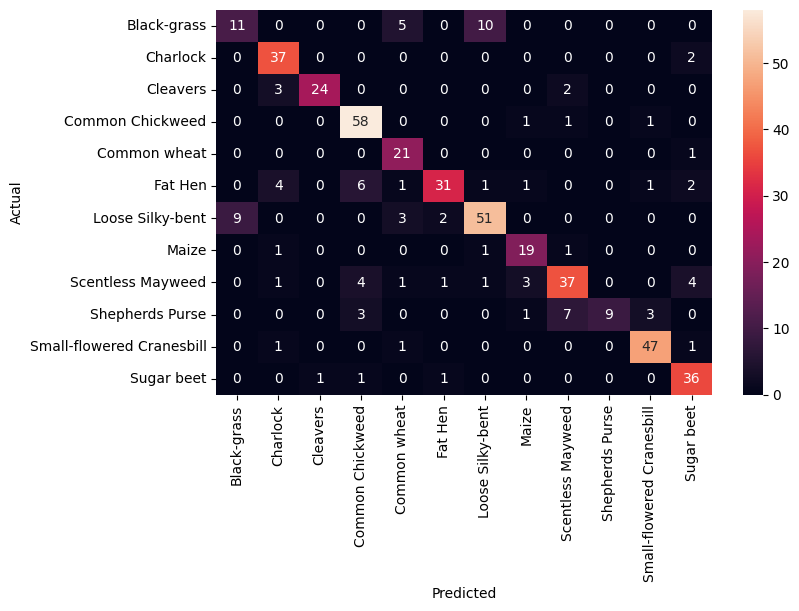

In [73]:
#Checking on test data
model_performance(model7,X_test_normalized,y_test_encoded)

* using data augmentation helps to significantly reduce the overfit, but the validation and test metrics are a bit worse than on the previous models

###Trying Adam optimizer with class weights

In [74]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [75]:
# Optional: Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train_encoded, axis=1)),  # Get the unique classes from the one-hot encoded labels
    y=np.argmax(y_train_encoded, axis=1)  # Pass the true class indices
)

# Convert to a dictionary to pass into model.fit
class_weight_dict = dict(enumerate(class_weights))

In [76]:
# Building the model
model8 = Sequential()
model8.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
model8.add(MaxPooling2D(2,2))
model8.add(BatchNormalization())
model8.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model8.add(MaxPooling2D(2,2))
model8.add(BatchNormalization())
model8.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model8.add(MaxPooling2D(2,2))
model8.add(Flatten())
model8.add(Dense(128, activation='relu'))
model8.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model8.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [77]:
history8 = model8.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            class_weight=class_weight_dict,
            verbose=0
)

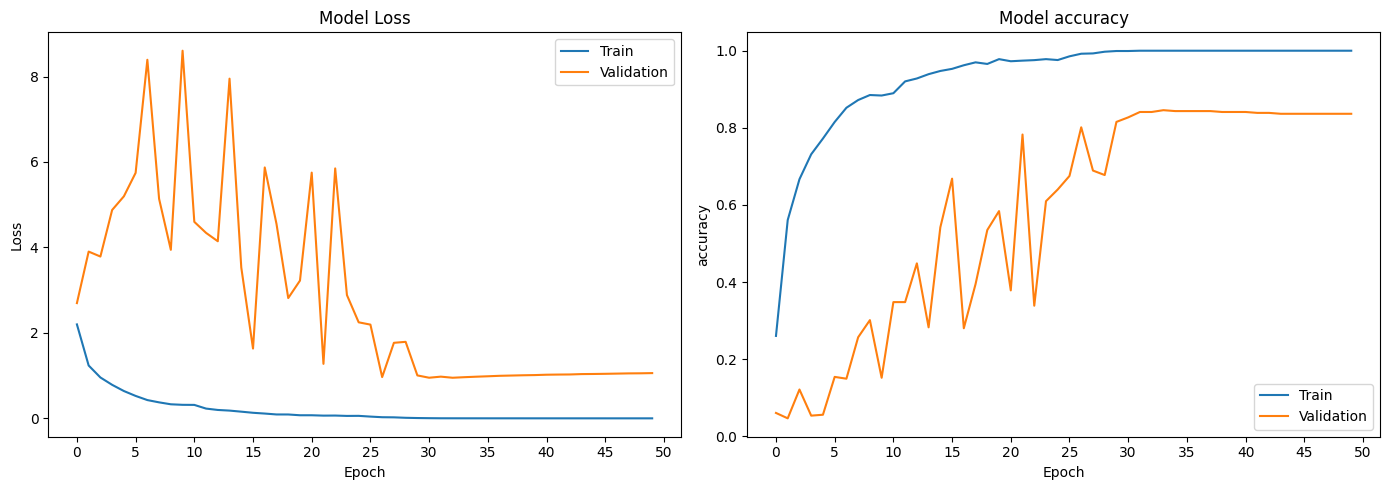

In [78]:
plot_metrics(history8)

In [79]:
model8_perf=model_metrics_train_val(model8,X_train_normalized,y_train_encoded,X_val_normalized,y_val_encoded)
model8_perf

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.836449,0.836449,0.832741,0.832283


In [80]:
#Checking on test data
accuracy8 = model8.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 46ms/step - accuracy: 0.8379 - loss: 0.8384


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                           precision    recall  f1-score   support

              Black-grass       0.50      0.50      0.50        26
                 Charlock       0.82      0.95      0.88        39
                 Cleavers       0.92      0.79      0.85        29
         Common Chickweed       0.89      0.93      0.91        61
             Common wheat       0.74      0.91      0.82        22
                  Fat Hen       0.86      0.89      0.88        47
         Loose Silky-bent       0.77      0.78      0.78        65
                    Maize       0.86      0.86      0.86        22
        Scentless Mayweed       0.81      0.88      0.84        52
          Shepherds Purse       0.92      0.48      0.63        23
Small-flowered Cranesbill       0.96      0.88      0.92        50
               Sugar beet       0.97      0.90      0.93        39

                 accuracy                           0.84       475
                macr

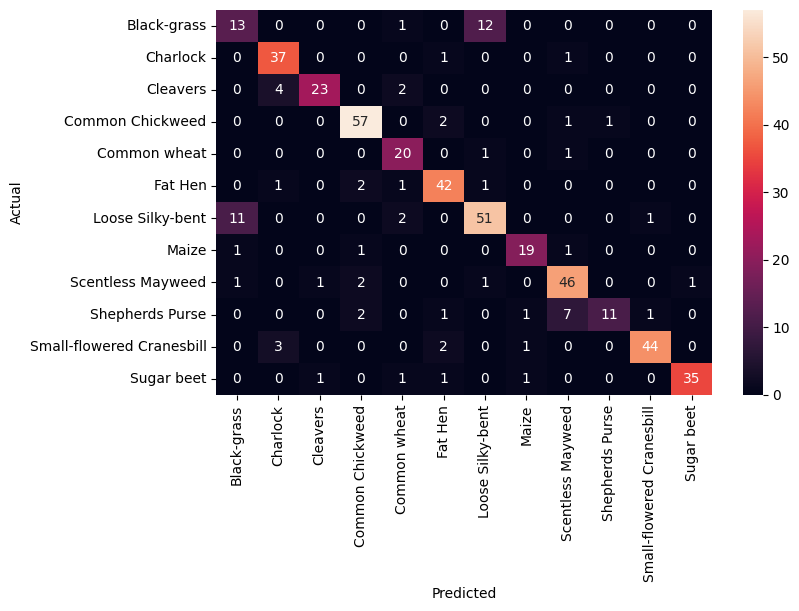

In [81]:
#Checking on test data
model_performance(model8,X_test_normalized,y_test_encoded)

* Using class weights to counteract the imbalance in the data classes doesn't help improve the overall performance

## Final Model

In [82]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model1_perf.iloc[0,:].T,
        model2_perf.iloc[0,:].T,
        model3_perf.iloc[0,:].T,
        model4_perf.iloc[0,:].T,
        model5_perf.iloc[0,:].T,
        model6_perf.iloc[0,:].T,
        model7_perf.iloc[0,:].T,
        model8_perf.iloc[0,:].T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
        "CNN, SGD optimizer",
        "CNN, SGD, Dropout, BatchNormalization",
        "CNN, SGD, BatchNormalization",
        "CNN, Adam, BatchNormalization",
        "CNN, Adam, Dropout, BatchNormalization",
        "CNN, Adam, BatchNormalization, changing LR",
        "CNN, Data Augmentation, Adam, BatchNormalization",
        "CNN, Adam, BatchNormalization, Class Weights"
]

In [83]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        model1_perf.iloc[1,:].T,
        model2_perf.iloc[1,:].T,
        model3_perf.iloc[1,:].T,
        model4_perf.iloc[1,:].T,
        model5_perf.iloc[1,:].T,
        model6_perf.iloc[1,:].T,
        model7_perf.iloc[1,:].T,
        model8_perf.iloc[1,:].T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
        "CNN, SGD optimizer",
        "CNN, SGD, Dropout, BatchNormalization",
        "CNN, SGD, BatchNormalization",
        "CNN, Adam, BatchNormalization",
        "CNN, Adam, Dropout, BatchNormalization",
        "CNN, Adam, BatchNormalization, changing LR",
        "CNN, Data Augmentation, Adam, BatchNormalization",
        "CNN, Adam, BatchNormalization, Class Weights"
]

models_val_comp_df.loc["Test Accuracy"]=[accuracy1[1], accuracy2[1], accuracy3[1], accuracy4[1], accuracy5[1], accuracy6[1], accuracy7[1], accuracy8[1]]

In [84]:
#Results on training dataset
models_train_comp_df

,"CNN, SGD optimizer","CNN, SGD, Dropout, BatchNormalization","CNN, SGD, BatchNormalization","CNN, Adam, BatchNormalization","CNN, Adam, Dropout, BatchNormalization","CNN, Adam, BatchNormalization, changing LR","CNN, Data Augmentation, Adam, BatchNormalization","CNN, Adam, BatchNormalization, Class Weights"
Accuracy,1.0,0.962308,1.0,1.0,0.880166,0.999740,0.848193,1.0
Recall,1.0,0.962308,1.0,1.0,0.880166,0.999740,0.848193,1.0
Precision,1.0,0.966590,1.0,1.0,0.918017,0.999741,0.843959,1.0
F1,1.0,0.962754,1.0,1.0,0.882023,0.999740,0.843338,1.0


In [85]:
# Results on validation dataset
models_val_comp_df

,"CNN, SGD optimizer","CNN, SGD, Dropout, BatchNormalization","CNN, SGD, BatchNormalization","CNN, Adam, BatchNormalization","CNN, Adam, Dropout, BatchNormalization","CNN, Adam, BatchNormalization, changing LR","CNN, Data Augmentation, Adam, BatchNormalization","CNN, Adam, BatchNormalization, Class Weights"
Accuracy,0.780374,0.794393,0.834112,0.845794,0.757009,0.841121,0.794393,0.836449
Recall,0.780374,0.794393,0.834112,0.845794,0.757009,0.841121,0.794393,0.836449
Precision,0.780616,0.807699,0.830496,0.844386,0.813813,0.837278,0.798404,0.832741
F1,0.776901,0.792781,0.829767,0.842199,0.757316,0.833088,0.787750,0.832283
Test Accuracy,0.787368,0.802105,0.863158,0.840000,0.768421,0.821053,0.802105,0.837895


* We can see that despite the overfit the models seem to generalize rather well - test accuracy is similar and in some cases even higher than validation accuracy
* I will be choosing model #4 (with Adam optimizer and BatchNormalization) - it shows the highest overall metrics on the validation dataset and same accuracy on the test set

In [91]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [92]:
# Building the model
final_model = Sequential()
final_model.add(Conv2D(128, (5,5), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
final_model.add(MaxPooling2D(2,2))
final_model.add(BatchNormalization())
final_model.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
final_model.add(MaxPooling2D(2,2))
final_model.add(BatchNormalization())
final_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
final_model.add(MaxPooling2D(2,2))
final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
final_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,572 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [93]:
history_final = final_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=0
)

### Visualizing the prediction

In [94]:
#Making predictions on the test data
y_pred_test = final_model.predict(X_test_normalized)

#Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


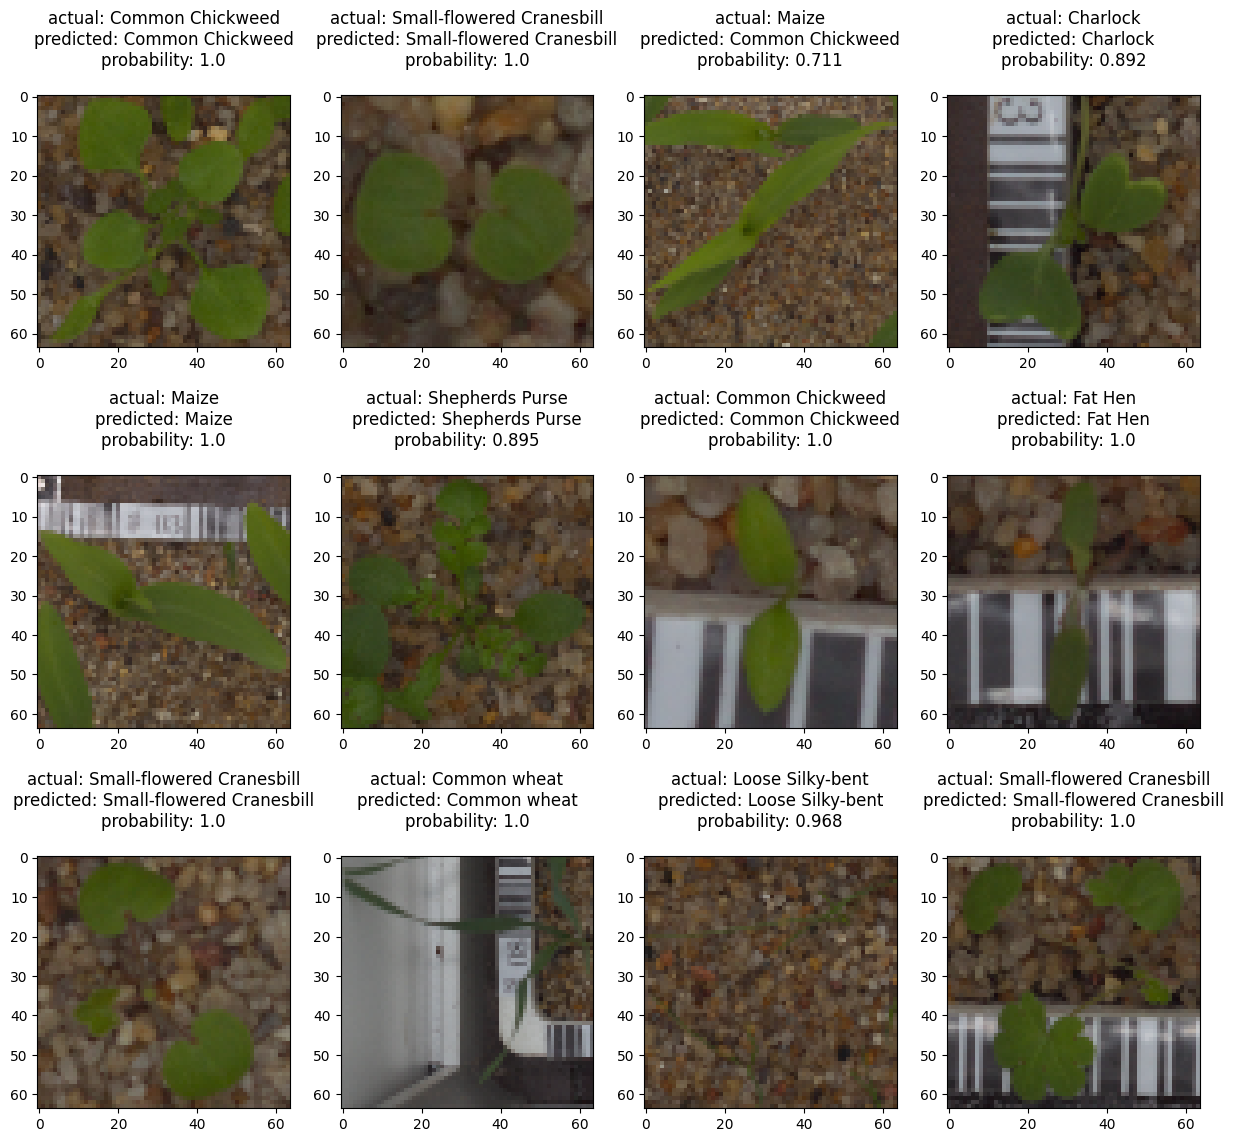

In [95]:
rows = 3
cols = 4
fig = plt.figure(figsize=(15, 14))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(X_test[random_index])
        pred_label = enc.inverse_transform(y_pred_test)[random_index]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = enc.inverse_transform(y_test_encoded)[random_index]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

## Actionable Insights and Business Recommendations

* We were able to achieve ~84% accuracy on the test set, which I consider to be a fair result
* We can try training further models to try and improve the validation and test scores even further - attemp training the models on the initial, not reduced 128*128 images, try a different architecture with other kernel sizes and different number of layers and different number of filters
* The most problematic distinction seems to be between Black-grass and Loose silky-bent, maybe we can try to train a separate model to differentiate specifically these 2 types of seedlings and then use combination of models - first classify whether the seedling is one of these two or not, and then have separate models, one that puts the image in one of the 10 other classes, and the second which makes the binary classification between Black-grass and Loose silky-bent.
* We can also try to use Transfer Learning and see if we can get better result utilizing some other pre-trained model

In [96]:
%%shell
jupyter nbconvert --to html /content/CV_Project_Full_Code_Notebook_Antonova.ipynb

[NbConvertApp] Converting notebook /content/CV_Project_Full_Code_Notebook_Antonova.ipynb to html
[NbConvertApp] Writing 4223679 bytes to /content/CV_Project_Full_Code_Notebook_Antonova.html
